In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#aca podemos ver el contenido que hay adentro de un file h5py

import h5py
snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_400.h5py', 'r')
def printname(name):
    print name
snap.visit(printname)

subhalo_000
subhalo_000/Center
subhalo_000/Drk
subhalo_000/Drk/Coordinates
subhalo_000/Drk/Ids
subhalo_000/Drk/Masses
subhalo_000/Drk/Velocities
subhalo_000/Gas
subhalo_000/Gas/Coordinates
subhalo_000/Gas/Density
subhalo_000/Gas/Ids
subhalo_000/Gas/InternalEnergy
subhalo_000/Gas/Masses
subhalo_000/Gas/Velocities
subhalo_000/R200
subhalo_000/Str
subhalo_000/Str/Coordinates
subhalo_000/Str/FormationTime
subhalo_000/Str/Ids
subhalo_000/Str/Masses
subhalo_000/Str/Metallicity
subhalo_000/Str/Velocities
subhalo_000/Time
subhalo_001
subhalo_001/Center
subhalo_001/Drk
subhalo_001/Drk/Coordinates
subhalo_001/Drk/Ids
subhalo_001/Drk/Masses
subhalo_001/Drk/Velocities
subhalo_001/Gas
subhalo_001/Gas/Coordinates
subhalo_001/Gas/Density
subhalo_001/Gas/Ids
subhalo_001/Gas/InternalEnergy
subhalo_001/Gas/Masses
subhalo_001/Gas/Velocities
subhalo_001/R200
subhalo_001/Str
subhalo_001/Str/Coordinates
subhalo_001/Str/FormationTime
subhalo_001/Str/Ids
subhalo_001/Str/Masses
subhalo_001/Str/Metallicity
subh

In [2]:
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time


In [15]:
#Graficos de Densidad de las Estrellas
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,29,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    a = snap['subhalo_000/Time'].value
    z = (a0/a)-1
    t = conv(z, h, omega_lambda, omega_matter)
    
    print isnap
    for i in range(9,10):
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Velocities'].value
        masa = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
#---------paso las coordenadas respecto al centro de la galaxia-------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
#---------------masas------------------------------------------        
        masa = masa/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
##esto sirve si quiero hacer una submuestra de mi conjunto de datos
       
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa[veloc]*vel[veloc,0])/sum(masa[veloc])
        vycm = sum(masa[veloc]*vel[veloc,1])/sum(masa[veloc])
        vzcm = sum(masa[veloc]*vel[veloc,2])/sum(masa[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
# utilizo una matriz de rotacion de modo que el plano xy coincida aprox con el plano del disco
# rot.rot, el primer rot es como yo le llamo arriba cuando importo, el segundo rot tiene que ver
#con como se llama la funcion adentro del archivo rotation
        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

#---------------------generador del gráfico-----------------
        corte,=np.where((xn<15) & (yn<15) & (zn<15) & (xn>-15) & (yn>-15) & (zn>-15))
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=5)

#----------escena del gráfico---------
        escena=sph.Scene(particles)

#--------como queres la escena-----------
        escena.set_autocamera(mode='density')
        rl=15
        
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        
#----renderizado de la escena (aca hace la grid y cuenta particulas)--------------
        rend=sph.Render(escena)
    
##extencion del grafico
        extent=escena.get_extent()
    
#-------escala logaritmica-----------------
        rend.set_logscale()
    
#-----rango que tiene la escala  de colores-----
        vmin=4
        vmax=9
        
# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='nipy_spectral'
    
#-----grafico-----------
        fig=plt.figure(5,figsize=(16,16))
        fig.subplots_adjust(bottom=0.08, left =0.09, right = 0.95, top = 0.95, wspace=0.05, hspace= 0.05)
        
        ax1=fig.add_subplot(221)
        ax1.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        plt.ylabel('z[kpc]', fontsize=30)
        ax1.set_title('sh_0'+ str('%s'%vector[i]), fontsize=30)
        ax1.minorticks_on()
        ax1.set_xticklabels([])
        ax1.tick_params( labelsize=26)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=5)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90, p=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        
        ax2=fig.add_subplot(222)
        ax2.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        plt.xlabel('y[kpc]', fontsize=30)
        ax2.minorticks_on()
        ax2.set_yticklabels([])
        ax2.tick_params( labelsize=26)
        ax2.tick_params('both', length=5, width=1.8,which='minor')
        ax2.tick_params('both', length=8, width=1.8,which='major')
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=5)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax3=fig.add_subplot(223)
        ax3.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        plt.xlabel('x[kpc]', fontsize=30)
        plt.ylabel('y[kpc]', fontsize=30)
        ax3.minorticks_on()
        ax3.tick_params( labelsize=26)
        ax3.tick_params('both', length=5, width=1.8,which='minor')
        ax3.tick_params('both', length=8, width=1.8,which='major')
        plt.text(5.5, 12.5,str('%.3f'%t)+'Gyr', fontsize=26, color='white')

        #fig.savefig('/home/ornela/python/Str1/'+'sh0'+str('%s'%vector[i])+'/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png',dpi = 80)
        #fig.savefig(str('%03d'%isnap)+'-'+str('%s'%vector[i])+'.png', dpi = 80)
        plt.show()
        #plt.clf()
        

497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248


497


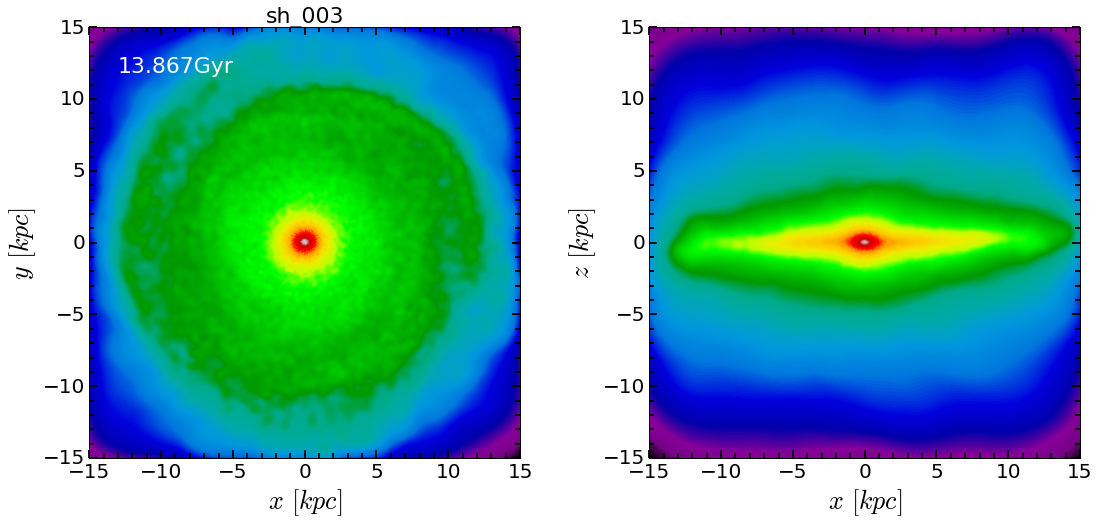

In [7]:
#Graficos de Densidad de las Estrellas

####PRUEBA PILOTO
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,496,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    a = snap['subhalo_000/Time'].value
    z = (a0/a)-1
    t = conv(z, h, omega_lambda, omega_matter)
    
    print isnap
    for i in range(2,3):
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Velocities'].value
        masa = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
#---------paso las coordenadas respecto al centro de la galaxia-------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
#---------------masas------------------------------------------        
        masa = masa/h
        
        rgal=0.15*r200
        
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
##esto sirve si quiero hacer una submuestra de mi conjunto de datos
       
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa[veloc]*vel[veloc,0])/sum(masa[veloc])
        vycm = sum(masa[veloc]*vel[veloc,1])/sum(masa[veloc])
        vzcm = sum(masa[veloc]*vel[veloc,2])/sum(masa[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
# utilizo una matriz de rotacion de modo que el plano xy coincida aprox con el plano del disco
# rot.rot, el primer rot es como yo le llamo arriba cuando importo, el segundo rot tiene que ver
#con como se llama la funcion adentro del archivo rotation
        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

#---------------------generador del gráfico-----------------
        rl=15    
        corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))
         
#-----rango que tiene la escala  de colores-----
        vmin=0
        vmax=9
        
# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='nipy_spectral'
    
#-----grafico-----------
        fig=plt.figure(1,figsize=(16,8))
        fig.subplots_adjust(bottom=0.08, left =0.09, right = 0.95, top = 0.95, wspace=0.3, hspace= 0.05)
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        
        ax1=fig.add_subplot(121)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        #plt.axis('off')
        ax1.set_title('sh_0'+ str('%s'%vector[i]), fontsize=22)
        plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=20)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')
        plt.text(-13, 13, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
        #              ha='center', va='center', 
        #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))
        
        #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')
        
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        
        ax2=fig.add_subplot(122)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        #plt.axis('off')
        plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        plt.ylabel('$z$'+' $[kpc]$', fontsize=26)
        ax2.minorticks_on()
        ax2.tick_params( labelsize=20)
        ax2.tick_params('both', length=5, width=1.8,which='minor')
        ax2.tick_params('both', length=8, width=1.8,which='major')
        #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
        

        #fig.savefig('/home/ornela/python/sem1/M31_3/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        #fig.savefig('/home/ornela/python/sem1/star2_'+str('%s'%vector[i])+'.png', dpi = 100)
        plt.show()
        #plt.clf()
        

In [4]:
#Graficos de Densidad de las Estrellas

####PRUEBA PILOTO 2
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np

h=0.732
a0=1
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
vector = ('00','01','03','09','13','14','18','19','20','21')

snapshot=range(497,200,-1)
for isnap in snapshot:
    snap = h5py.File('/home/ornela/python/ornella/outputs_1/snap_'+str('%03d'%isnap)+'.h5py', 'r')

    a = snap['subhalo_000/Time'].value
    z = (a0/a)-1
    t = conv(z, h, omega_lambda, omega_matter)
    
    print isnap
    for i in range(1,2):
        pstr = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Coordinates'].value
        cm   = snap['subhalo_0'+ str('%s'%vector[i]) +'/Center'].value
        vel  = snap['subhalo_0'+ str('%s'%vector[i]) + '/Str/Velocities'].value
        masa = snap['subhalo_0'+ str('%s'%vector[i]) +'/Str/Masses'].value
        r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value
        
#---------paso las coordenadas respecto al centro de la galaxia-------
        xstr = (pstr[:,0]-cm[0])/h
        ystr = (pstr[:,1]-cm[1])/h
        zstr = (pstr[:,2]-cm[2])/h
        r = np.sqrt(xstr**2+ystr**2+zstr**2)
        
#---------------masas------------------------------------------        
        masa = masa/h
        
        rgal=0.15*r200
        #print r200
        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])
                
        Mc = np.cumsum((masa[limit])[r_indice])
        Mgal = Mc[-1]
               
        razon = Mc/Mgal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)
        
        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
#------------------------------------------------------------------        
##esto sirve si quiero hacer una submuestra de mi conjunto de datos
       
        veloc,=np.where(r<r50[-1])
        
#----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa[veloc]*vel[veloc,0])/sum(masa[veloc])
        vycm = sum(masa[veloc]*vel[veloc,1])/sum(masa[veloc])
        vzcm = sum(masa[veloc]*vel[veloc,2])/sum(masa[veloc])
        
#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm
        
# utilizo una matriz de rotacion de modo que el plano xy coincida aprox con el plano del disco
# rot.rot, el primer rot es como yo le llamo arriba cuando importo, el segundo rot tiene que ver
#con como se llama la funcion adentro del archivo rotation
        if isnap == 497: 
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

#---------------------generador del gráfico-----------------
        rl=70    
        corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))
         
#-----rango que tiene la escala  de colores-----
        vmin=0
        vmax=9
        
# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='nipy_spectral'
    
#-----grafico-----------
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.08, left =0.09, right = 0.95, top = 0.95, wspace=0.3, hspace= 0.05)
        
        particles=sph.Particles(pos[:,corte],masa[corte]*1e10,nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()
        
        ax1=fig.add_subplot(111)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap)
        #plt.axis('off')
        #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        #plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
        #ax1.minorticks_on()
        #ax1.tick_params( labelsize=20)
        #ax1.tick_params('both', length=5, width=1.8,which='minor')
        #ax1.tick_params('both', length=8, width=1.8,which='major')
        plt.text(-67, 67, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        plt.annotate("",xy=(37, -67), xycoords='data',xytext=(67, -67),textcoords='data',
                      ha='center', va='center', 
                     arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))
        
        plt.text(52, -67, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')
        
        
        fig.savefig('/home/ornela/python/sem1/MW_2/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        #fig.savefig('/home/ornela/python/sem1/star3_'+str('%s'%vector[i])+'.png', dpi = 100)
        #plt.show()
        plt.clf()
        

497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376
375
374
373
372
371
370
369
368
367
366
365
364
363
362
361
360
359
358
357
356
355
354
353
352
351
350
349
348
347
346
345
344
343
342
341
340
339
338
337
336
335
334
333
332
331
330
329
328
327
326
325
324
323
322
321
320
319
318
317
316
315
314
313
312
311
310
309
308
307
306
305
304
303
302
301
300
299
298
297
296
295
294
293
292
291
290
289
288
287
286
285
284
283
282
281
280
279
278
277
276
275
274
273
272
271
270
269
268
267
266
265
264
263
262
261
260
259
258
257
256
255
254
253
252
251
250
249
248
